In [2]:
from typing import Union
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn.metrics import mean_squared_error

In [3]:
def load_dataset(file_path: str) -> Union[pd.DataFrame, None]:
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file_path}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"Error: Unable to parse file '{file_path}'. Please check the file format.")
        return None

    return df

In [4]:
def convert(word):
    return ''.join(x.capitalize() or '_' for x in word.split('_'))

In [5]:
def statistical_measure(data_column_1: pd.DataFrame , data_column_2: pd.DataFrame):
    correlation_pearson, _ = pearsonr(data_column_1.values, data_column_2.values)
    correlation_spearman, _ = spearmanr(data_column_1.values, data_column_2.values)

    mse = mean_squared_error(data_column_1.values, data_column_2.values)

    relative_difference = np.mean(np.abs(data_column_1.values - data_column_2.values) / np.mean([data_column_1.values, data_column_2.values]) * 100)

    return correlation_pearson, correlation_spearman, mse, relative_difference

def extend_legend(ax, df_1, df_2, data_column):
    min_length = min(len(df_1), len(df_2))

    df_1 = df_1.iloc[:min_length, :]
    df_2 = df_2.iloc[:min_length, :]
    df_1_desc = df_1[data_column].describe()
    df_2_desc = df_2[data_column].describe()

    correlation_pearson, correlation_spearman, mse, relative_difference = statistical_measure(df_1[data_column], df_2[data_column])
    ax.plot([], [], ' ', label=f"Correlation Pearson: {round(correlation_pearson, 3)}")
    ax.plot([], [], ' ', label=f"Correlation Spearman: {round(correlation_spearman, 3)}")
    ax.plot([], [], ' ', label=f"MSE: {round(mse, 3)}")
    ax.plot([], [], ' ', label=f"Relative Difference: {round(relative_difference, 3)}")

    ax.plot([], [], ' ', label=f"Mean Cpp: {round(df_1_desc['mean'],3)}")
    ax.plot([], [], ' ', label=f"Std Cpp: {round(df_1_desc['std'],3)}")
    ax.plot([], [], ' ', label=f"Min Cpp: {round(df_1_desc['min'],3)}")
    ax.plot([], [], ' ', label=f"Max Cpp: {round(df_1_desc['max'],3)}")

    ax.plot([], [], ' ', label=f"Mean Python: {round(df_2_desc['mean'],3)}")
    ax.plot([], [], ' ', label=f"Std Python: {round(df_2_desc['std'],3)}")
    ax.plot([], [], ' ', label=f"Min Python: {round(df_2_desc['min'],3)}")
    ax.plot([], [], ' ', label=f"Max Python: {round(df_2_desc['max'],3)}") 

In [6]:
blue_palette = ['#00008B']
warm_palette = ['#ee092d']

def plot_dataframe(ax, file_path: str, data_column, label: str=None):
    df = load_dataset(file_path)[['simulation_time', data_column]]

    row = df[df['simulation_time']>=10].index.tolist()
    if row != []:
        df = df.iloc[:row[0]-1] 

    min_value = df[data_column].min()
    df[data_column] -= min_value

    color = blue_palette if 'cpp' in label else warm_palette
    ax.plot(df.iloc[:, 0], df.iloc[:, 1], label=label, color=random.choice(color))
    
    return df

def plot_dataframe_dataload(ax, file_path: str,  data_colum: str, label: str=None, shift=False):
    df = load_dataset(file_path)[['simulation_time', data_colum]]

    row = df[df[data_colum]>0].index.tolist()
    if row != []:
        df = df.iloc[row[0]-1:] 

    if shift:
        min_value = df['simulation_time'].min()
        df['simulation_time'] -= min_value

    row = df[df['simulation_time']>=10].index.tolist()
    if row != []:
        df = df.iloc[:row[0]-1] 

    color = blue_palette if 'cpp' in label else warm_palette
    ax.plot(df.loc[:, 'simulation_time'], df.loc[:, data_colum], label=label, color=random.choice(color))

    return df

In [7]:
# Startup times
# Omnet: 10,46s 
# Python: 4,31s

In [19]:
blue_palette = ['#03045e', '#0077b6', '#00b4d8']
warm_palette = ['#d00000', '#e85d04', '#faa307']

fig1, axs1 = plt.subplots(4,1, figsize=(15, 30))
paths = [5, 15, 25]
folders = ["cpp", "python"]
data_columns = ["current_data_load"]

mobile_ids = {
    "python" : [[1,2], [1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
    "cpp" : [[7,8], [7, 8, 9, 10, 11, 12, 13], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]],
}

sensor_ids = {
    "python" : [[1,2,3,4,5], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
    "cpp" : [[7,8,9,10,11], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]],
}

for idx_path, path in enumerate(paths):

    dfs = {
        "cpp" : pd.DataFrame(),
        "python" : pd.DataFrame(),
    }

    for idx_folder, folder in enumerate(folders):
        for idx_data_column, data_column in enumerate(data_columns):
            
            base_file_path = f"./simulation_results/{path}/results/express/{folder}/tracked_variables_ZigZagProtocolMobile_"

            for mobile_id in mobile_ids[folder][idx_path]:
                # Load dataset and rename for merge
                # tmp_df = load_dataset(base_file_path + f"{mobile_id}.csv")[['simulation_time', data_column]]
                # tmp_df = tmp_df.rename(columns={data_column: f"{data_column}_{mobile_id}"})

                # # Merge
                # dfs[folder] = tmp_df if len(dfs[folder]) == 0 else pd.merge(dfs[folder], tmp_df, on='simulation_time', how='inner')

            #     tmp_df_resampled = load_dataset(base_file_path + f"{mobile_id}.csv")[['simulation_time', data_column]]
            #     tmp_df_resampled['simulation_time'] = pd.to_datetime(tmp_df_resampled['simulation_time'], unit='s')
            #     tmp_df_resampled = tmp_df_resampled.set_index('simulation_time')
            #     tmp_df_resampled = tmp_df_resampled.resample('0.1S').mean().interpolate()
            #     tmp_df_resampled['simulation_time_1'] = tmp_df_resampled.index.time
            #     tmp_df_resampled['simulation_time_2'] =  tmp_df_resampled['simulation_time_1'].apply(lambda x: x.strftime('%M.%S%f'))
            #     tmp_df = tmp_df_resampled.rename(columns={data_column: f"{data_column}_{mobile_id}"}).reset_index()[['simulation_time_2',f"{data_column}_{mobile_id}"]]
            #     tmp_df = tmp_df.rename(columns={"simulation_time_2": "simulation_time"})
            #     tmp_df['simulation_time'] = tmp_df['simulation_time'].astype(float)

            #     dfs[folder] = tmp_df if len(dfs[folder]) == 0 else pd.merge(dfs[folder], tmp_df, on='simulation_time', how='inner')

            # dfs[folder][f'{data_column}'] = dfs[folder].loc[:, dfs[folder].columns != 'simulation_time'].mean(axis=1) 
        
            # dfs[folder] = dfs[folder][['simulation_time', data_column]]

                tmp_df_resampled = load_dataset(base_file_path + f"{mobile_id}.csv")[['simulation_time', data_column]]
                tmp_df_resampled['simulation_time'] = pd.to_datetime(tmp_df_resampled['simulation_time'], unit='s')
                tmp_df_resampled = tmp_df_resampled.set_index('simulation_time')
                tmp_df_resampled = tmp_df_resampled.resample('0.1S').mean().interpolate()
                tmp_df_resampled['simulation_time_1'] = tmp_df_resampled.index.time
                tmp_df_resampled['simulation_time_2'] =  tmp_df_resampled['simulation_time_1'].apply(lambda x: x.strftime('%M.%S%f'))
                tmp_df = tmp_df_resampled.rename(columns={data_column: f"{data_column}_{mobile_id}"}).reset_index()[['simulation_time_2',f"{data_column}_{mobile_id}"]]
                tmp_df = tmp_df.rename(columns={"simulation_time_2": "simulation_time"})
                tmp_df['simulation_time'] = tmp_df['simulation_time'].astype(float)
                tmp_df['simulation_time'] = tmp_df['simulation_time'] * 60

                dfs[folder] = tmp_df if len(dfs[folder]) == 0 else pd.merge(dfs[folder], tmp_df, on='simulation_time', how='inner')

            dfs[folder][f'{data_column}'] = dfs[folder].loc[:, dfs[folder].columns != 'simulation_time'].mean(axis=1) 
        
            dfs[folder] = dfs[folder][['simulation_time', data_column]]


    for key, items in dfs.items():
        color = blue_palette if 'cpp' in key else warm_palette

        label = f"{len(sensor_ids[key][idx_path])} Sensors - {len(mobile_ids[key][idx_path])} UAVs - {'OMNET++/INET plus Python' if key == 'cpp' else 'Only Python'}"
        # Create a combined graph
        axs1[0].plot(items.iloc[:, 0], items.iloc[:, 1], label=label, color=color[idx_path])
        
        if idx_path == 0:
            axs1[0].set_title(f'Simulated Time vs. Data Load - Express - UAVs Mobile Nodes')
            axs1[0].set_xlabel('Simulated Time in Seconds')
            axs1[0].set_ylabel('Amount of Collected Packages')

        # Create a graph for each individually
        axs1[idx_path + 1].plot(items.iloc[:, 0], items.iloc[:, 1], label=label, color=color[idx_path])
        axs1[idx_path + 1].set_title(f'Simulated Time vs. Data Load - Express - UAVs Mobile Nodes')
        
        axs1[idx_path + 1].set_xlabel('Simulated Time in Seconds')
        axs1[idx_path + 1].set_ylabel('Amount of Collected Packages')
        axs1[idx_path + 1].legend()

axs1[0].legend()

Error: File './simulation_results/25/results/with_visualization/cpp/tracked_variables_ZigZagProtocolMobile_7.csv' not found.


TypeError: 'NoneType' object is not subscriptable

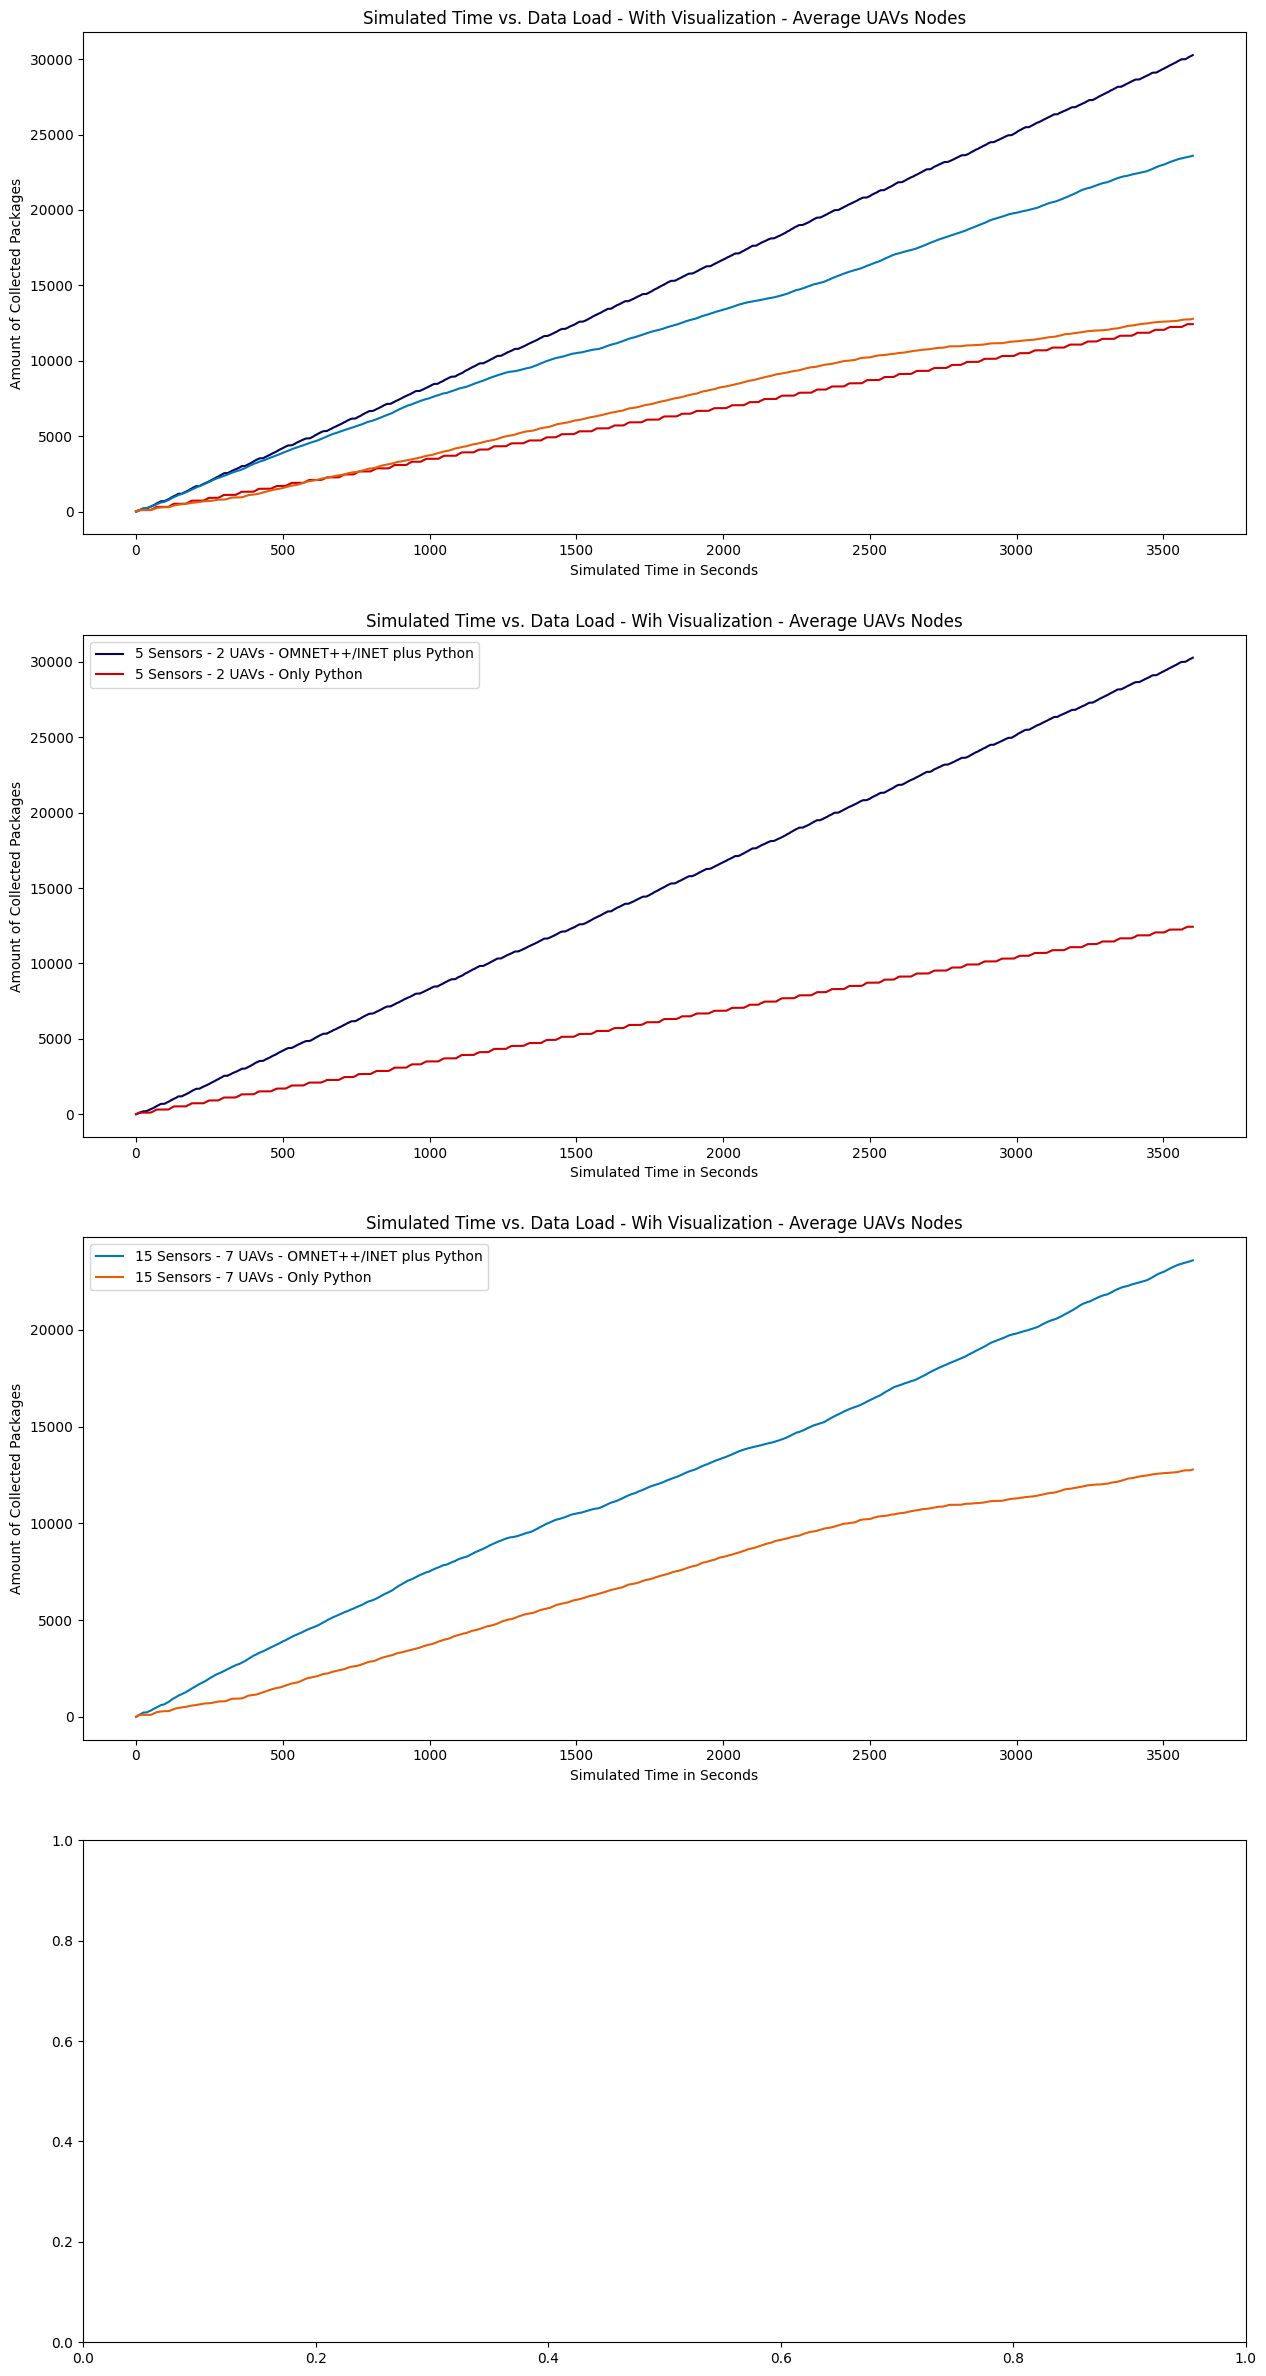

In [9]:
blue_palette = ['#03045e', '#0077b6', '#00b4d8']
warm_palette = ['#d00000', '#e85d04', '#faa307']

fig1, axs1 = plt.subplots(4,1, figsize=(15, 30))
paths = [5, 15, 25]
folders = ["cpp", "python"]
data_columns = ["current_data_load"]

mobile_ids = {
    "python" : [[1,2], [1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
    "cpp" : [[7,8], [7, 8, 9, 10, 11, 12, 13], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]],
}

sensor_ids = {
    "python" : [[1,2,3,4,5], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
    "cpp" : [[7,8,9,10,11], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]],
}

for idx_path, path in enumerate(paths):

    dfs = {
        "cpp" : pd.DataFrame(),
        "python" : pd.DataFrame(),
    }

    for idx_folder, folder in enumerate(folders):
        for idx_data_column, data_column in enumerate(data_columns):
            
            base_file_path = f"./simulation_results/{path}/results/with_visualization/{folder}/tracked_variables_ZigZagProtocolMobile_"

            for mobile_id in mobile_ids[folder][idx_path]:
                # Load dataset and rename for merge
                tmp_df = load_dataset(base_file_path + f"{mobile_id}.csv")[['simulation_time', data_column]]
                tmp_df = tmp_df.rename(columns={data_column: f"{data_column}_{mobile_id}"})

                # Merge
                dfs[folder] = tmp_df if len(dfs[folder]) == 0 else pd.merge(dfs[folder], tmp_df, on='simulation_time', how='inner')

            dfs[folder][f'{data_column}'] = dfs[folder].loc[:, dfs[folder].columns != 'simulation_time'].mean(axis=1) 
        
            dfs[folder] = dfs[folder][['simulation_time', data_column]]

    for key, items in dfs.items():
        color = blue_palette if 'cpp' in key else warm_palette

        label = f"{len(sensor_ids[key][idx_path])} Sensors - {len(mobile_ids[key][idx_path])} UAVs - {'OMNET++/INET plus Python' if key == 'cpp' else 'Only Python'}"
        # Create a combined graph
        axs1[0].plot(items.iloc[:, 0], items.iloc[:, 1], label=label, color=color[idx_path])
        
        if idx_path == 0:
            axs1[0].set_title(f'Simulated Time vs. Data Load - With Visualization - Average UAVs Nodes')
            axs1[0].set_xlabel('Simulated Time in Seconds')
            axs1[0].set_ylabel('Amount of Collected Packages')

        # Create a graph for each individually
        axs1[idx_path + 1].plot(items.iloc[:, 0], items.iloc[:, 1], label=label, color=color[idx_path])
        axs1[idx_path + 1].set_title(f'Simulated Time vs. Data Load - Wih Visualization - Average UAVs Nodes')
        
        axs1[idx_path + 1].set_xlabel('Simulated Time in Seconds')
        axs1[idx_path + 1].set_ylabel('Amount of Collected Packages')
        axs1[idx_path + 1].legend()

axs1[0].legend()

Error: File './simulation_results/25/results/express/cpp/simulation_real_time_ZigZagProtocolMobile_7.csv' not found.


TypeError: 'NoneType' object is not subscriptable

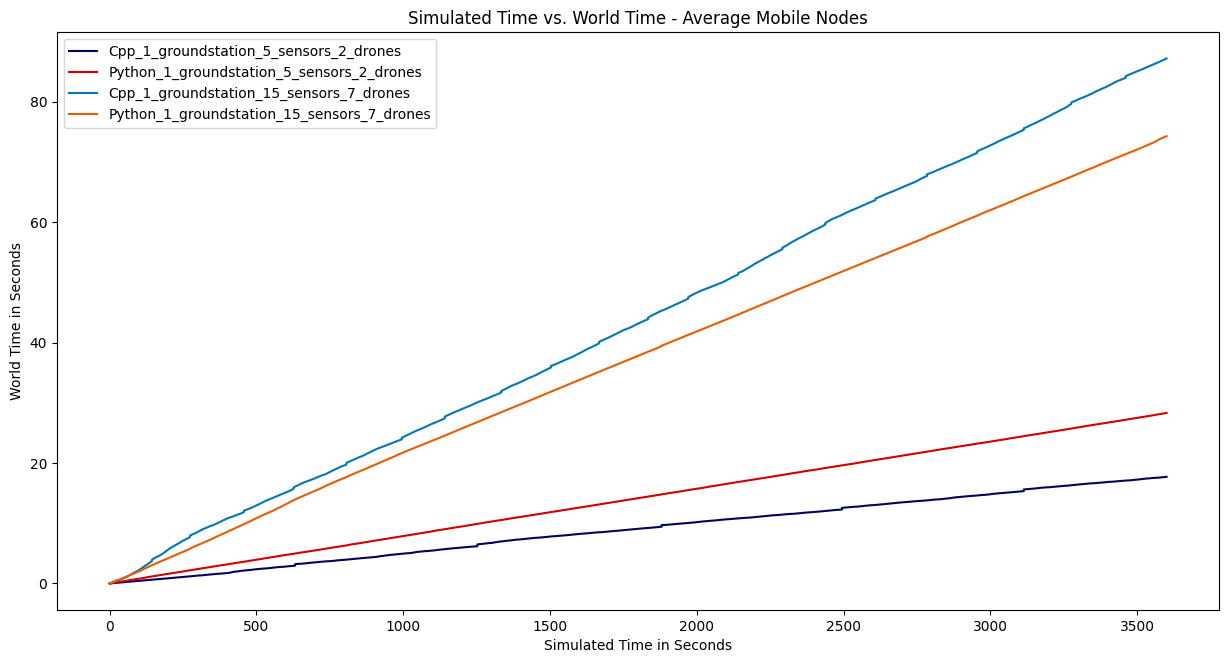

In [10]:
blue_palette = ['#03045e', '#0077b6', '#00b4d8']
warm_palette = ['#d00000', '#e85d04', '#faa307']

fig1, axs1 = plt.subplots(1,1, figsize=(15, 7.5))
paths = [5, 15, 25]
folders = ["cpp", "python"]
data_columns = ["real_time"]

mobile_ids = {
    "python" : [[1,2], [1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
    "cpp" : [[7,8], [7, 8, 9, 10, 11, 12, 13], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]],
}

sensor_ids = {
    "python" : [[1,2,3,4,5], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
    "cpp" : [[7,8,9,10,11], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]],
}

for idx_path, path in enumerate(paths):

    dfs = {
        "cpp" : pd.DataFrame(),
        "python" : pd.DataFrame(),
    }

    for idx_folder, folder in enumerate(folders):
        for idx_data_column, data_column in enumerate(data_columns):
            
            base_file_path = f"./simulation_results/{path}/results/express/{folder}/simulation_real_time_ZigZagProtocolMobile_"

            for mobile_id in mobile_ids[folder][idx_path]:
                # Load dataset and rename for merge
                tmp_df = load_dataset(base_file_path + f"{mobile_id}.csv")[['simulation_time', data_column]]

                min_value = tmp_df[data_column].min()
                tmp_df[data_column] -= min_value

                tmp_df = tmp_df.rename(columns={data_column: f"{data_column}_{mobile_id}"})

                # Merge
                dfs[folder] = tmp_df if len(dfs[folder]) == 0 else pd.merge(dfs[folder], tmp_df, on='simulation_time', how='inner')

            dfs[folder][f'{data_column}'] = dfs[folder].loc[:, dfs[folder].columns != 'simulation_time'].mean(axis=1) 
        
            dfs[folder] = dfs[folder][['simulation_time', data_column]]

    for key, items in dfs.items():
        color = blue_palette if 'cpp' in key else warm_palette
        axs1.plot(items.iloc[:, 0], items.iloc[:, 1], label=f"{convert(key)}_1_groundstation_{len(sensor_ids[key][idx_path])}_sensors_{len(mobile_ids[key][idx_path])}_drones", color=color[idx_path])
        axs1.set_title(f'Simulated Time vs. World Time - Average Mobile Nodes')
        
        axs1.set_xlabel('Simulated Time in Seconds')
        axs1.set_ylabel('World Time in Seconds')
    
    # extend_legend(axs1, dfs["cpp"], dfs["python"], data_column)
    axs1.legend()


Error: File './simulation_results/25/results/with_visualization/cpp/simulation_real_time_ZigZagProtocolMobile_7.csv' not found.


TypeError: 'NoneType' object is not subscriptable

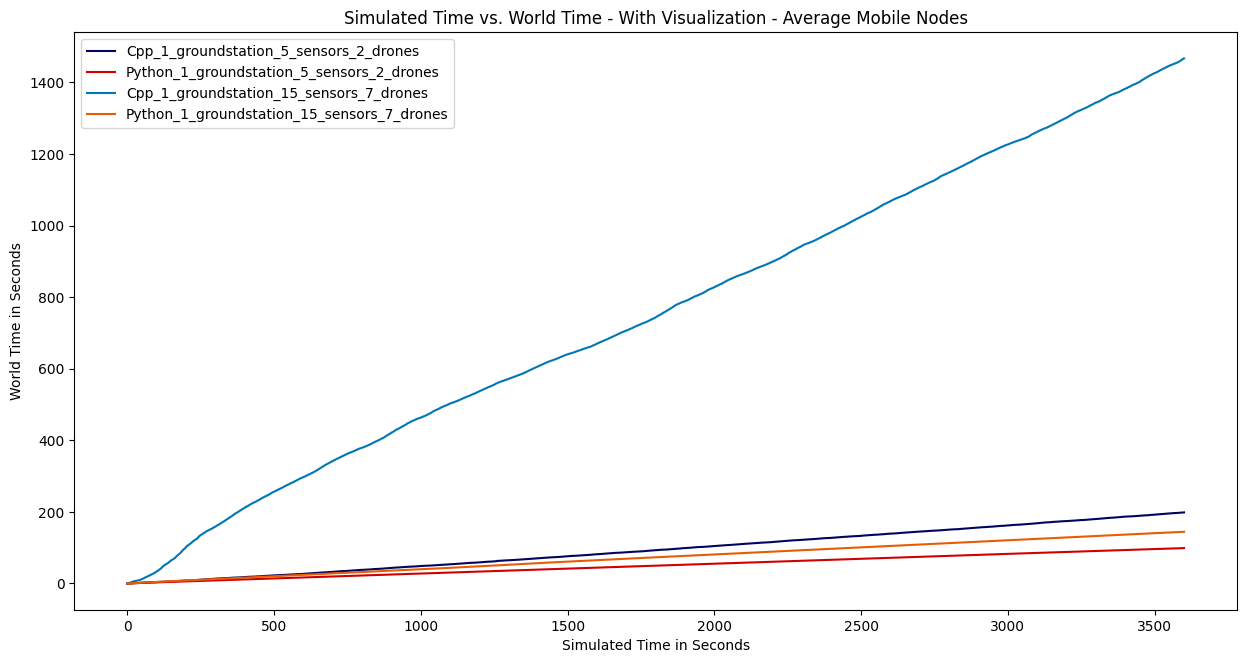

In [11]:
blue_palette = ['#03045e', '#0077b6', '#00b4d8']
warm_palette = ['#d00000', '#e85d04', '#faa307']

fig1, axs1 = plt.subplots(1,1, figsize=(15, 7.5))
paths = [5, 15, 25]
folders = ["cpp", "python"]
data_columns = ["real_time"]

mobile_ids = {
    "python" : [[1,2], [1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
    "cpp" : [[7,8], [7, 8, 9, 10, 11, 12, 13], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]],
}

sensor_ids = {
    "python" : [[1,2,3,4,5], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
    "cpp" : [[7,8,9,10,11], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]],
}

for idx_path, path in enumerate(paths):

    dfs = {
        "cpp" : pd.DataFrame(),
        "python" : pd.DataFrame(),
    }

    for idx_folder, folder in enumerate(folders):
        for idx_data_column, data_column in enumerate(data_columns):
            
            base_file_path = f"./simulation_results/{path}/results/with_visualization/{folder}/simulation_real_time_ZigZagProtocolMobile_"

            for mobile_id in mobile_ids[folder][idx_path]:
                # Load dataset and rename for merge
                tmp_df = load_dataset(base_file_path + f"{mobile_id}.csv")[['simulation_time', data_column]]

                min_value = tmp_df[data_column].min()
                tmp_df[data_column] -= min_value

                tmp_df = tmp_df.rename(columns={data_column: f"{data_column}_{mobile_id}"})

                # Merge
                dfs[folder] = tmp_df if len(dfs[folder]) == 0 else pd.merge(dfs[folder], tmp_df, on='simulation_time', how='inner')

            dfs[folder][f'{data_column}'] = dfs[folder].loc[:, dfs[folder].columns != 'simulation_time'].mean(axis=1) 
        
            dfs[folder] = dfs[folder][['simulation_time', data_column]]

    for key, items in dfs.items():
        color = blue_palette if 'cpp' in key else warm_palette
        axs1.plot(items.iloc[:, 0], items.iloc[:, 1], label=f"{convert(key)}_1_groundstation_{len(sensor_ids[key][idx_path])}_sensors_{len(mobile_ids[key][idx_path])}_drones", color=color[idx_path])
        axs1.set_title(f'Simulated Time vs. World Time - With Visualization - Average Mobile Nodes')
        
        axs1.set_xlabel('Simulated Time in Seconds')
        axs1.set_ylabel('World Time in Seconds')
    
    # extend_legend(axs1, dfs["cpp"], dfs["python"], data_column)
    axs1.legend()


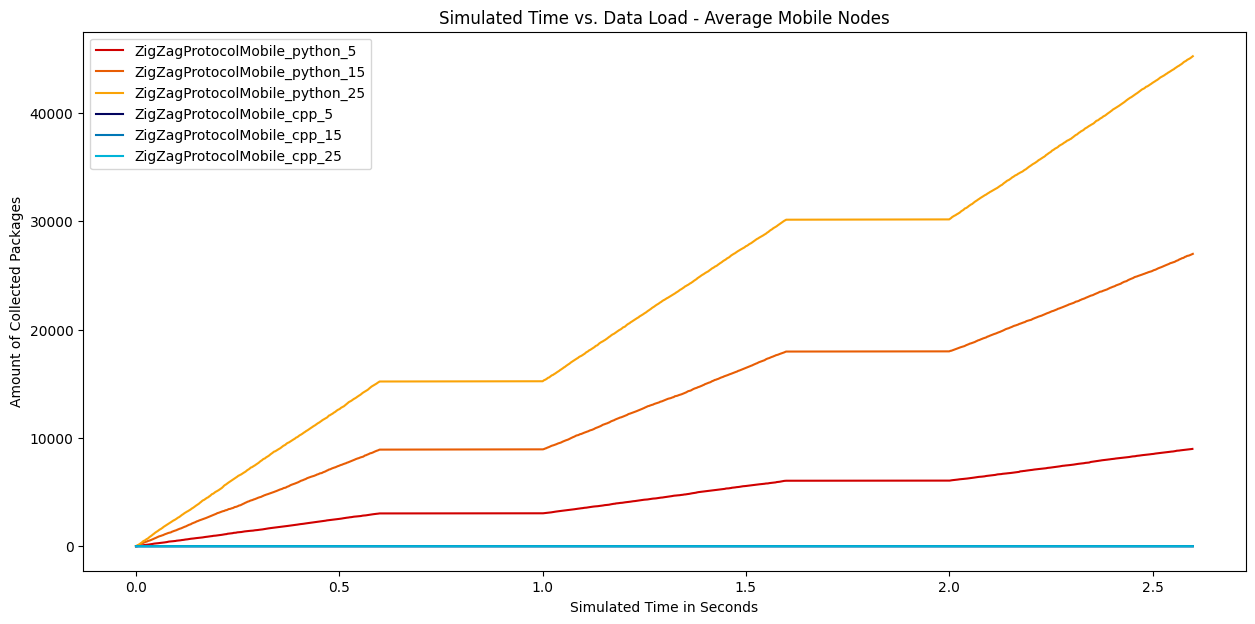

In [26]:
blue_palette = ['#03045e', '#0077b6', '#00b4d8']
warm_palette = ['#d00000', '#e85d04', '#faa307']

fig4, axs4 = plt.subplots(1,1, figsize=(15, 7))
paths = ["express"]
codes = ["python"]
data_columns = ["current_data_load"]
amount_mobile_sensors = [5,15,25]


lists = {
    "python" : [ [1,2,3,4,5], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]],
    "cpp" : [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]],
}

for idx_amount_mobile_sensor, amount_mobile_sensor in enumerate(amount_mobile_sensors):
    for idx_path, path in enumerate(paths):
        for idx_data_column, data_column in enumerate(data_columns):
            
            dfs = {
                # "cpp" : pd.DataFrame(),
                "python" : pd.DataFrame(),

            }

            for idx_code, code in enumerate(codes): 
                base_file_path = f"./exemplary_simulation_results/{path}/{code}/{amount_mobile_sensor}/tracked_variables_{code}_{path}_{amount_mobile_sensor}_ZigZagProtocolMobile_"

                elem_list = lists[code][idx_amount_mobile_sensor]
                for elem in elem_list:
                    tmp_df_resampled = load_dataset(base_file_path + f"{elem}.csv")[['simulation_time', data_column]]
                    tmp_df_resampled['simulation_time'] = pd.to_datetime(tmp_df_resampled['simulation_time'], unit='s')
                    tmp_df_resampled = tmp_df_resampled.set_index('simulation_time')
                    tmp_df_resampled = tmp_df_resampled.resample('0.1S').mean().interpolate()
                    tmp_df_resampled['simulation_time_1'] = tmp_df_resampled.index.time
                    tmp_df_resampled['simulation_time_2'] =  tmp_df_resampled['simulation_time_1'].apply(lambda x: x.strftime('%M.%S%f'))
                    tmp_df = tmp_df_resampled.rename(columns={data_column: f"{data_column}_{elem}"}).reset_index()[['simulation_time_2',f"{data_column}_{elem}"]]
                    tmp_df = tmp_df.rename(columns={"simulation_time_2": "simulation_time"})
                    tmp_df['simulation_time'] = tmp_df['simulation_time'].astype(float)

                    dfs[code] = tmp_df if len(dfs[code]) == 0 else pd.merge(dfs[code], tmp_df, on='simulation_time', how='inner')

                dfs[code][f'{data_column}'] = dfs[code].loc[:, dfs[code].columns != 'simulation_time'].mean(axis=1) 
            
                dfs[code] = dfs[code][['simulation_time', data_column]]

            index = 0

            for key, items in dfs.items():
                color = blue_palette if 'cpp' in key else warm_palette
                axs4.plot(items.iloc[:, 0], items.iloc[:, 1], label=f"ZigZagProtocolMobile_{key}_{amount_mobile_sensor}", color=color[idx_amount_mobile_sensor])
                axs4.set_title(f'Simulated Time vs. Data Load - Average Mobile Nodes')
                
                axs4.set_xlabel('Simulated Time in Seconds')
                axs4.set_ylabel('Amount of Collected Packages')
            
            # extend_legend(axs4, dfs["cpp"], dfs["python"], data_column)


for i in range (3): 
    base_file_path = f"./exemplary_simulation_results/express/cpp/15_7/tracked_variables_cpp_express_15_ZigZagProtocolMobile_"

    dfs["python"]["current_data_load"].values[:] = 0

    dfs['cpp'] = dfs["python"]
    
    color = blue_palette
    axs4.plot(dfs['cpp'].iloc[:, 0], dfs['cpp'].iloc[:, 1], label=f"ZigZagProtocolMobile_cpp_{amount_mobile_sensors[i]}", color=color[i])
    
axs4.legend()